In [1]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords

# Download NLTK stopwords
nltk.download("stopwords")
stop_words = set(stopwords.words("english"))

# Step 1: Load the Dataset
file_path = "/content/Brain Dead CompScholar Dataset.csv"  # Update with the actual file path
df = pd.read_csv(file_path)

# Step 2: Select Relevant Columns
df = df[["Paper Title", "Abstract", "Conclusion", "Summary"]]

# Step 3: Handle Missing Values
df.dropna(inplace=True)  # Removing rows with missing values

# Step 4: Text Cleaning Function
def clean_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r"\s+", " ", text)  # Remove extra spaces
    text = re.sub(r"[^a-zA-Z0-9.,!?]", " ", text)  # Remove special characters
    text = " ".join([word for word in text.split() if word not in stop_words])  # Remove stopwords
    return text

# Apply Cleaning to Text Columns
df["Paper Title"] = df["Paper Title"].apply(clean_text)
df["Abstract"] = df["Abstract"].apply(clean_text)
df["Conclusion"] = df["Conclusion"].apply(clean_text)
df["Summary"] = df["Summary"].apply(clean_text)

# Step 5: Combine Relevant Sections for Summarization Task
df["Document"] = df["Paper Title"] + " " + df["Abstract"] + " " + df["Conclusion"]

# Step 6: Save Processed Data
df.to_csv("CompScholar_Cleaned.csv", index=False)

print("Preprocessing complete. Cleaned data saved as 'CompScholar_Cleaned.csv'.")


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Preprocessing complete. Cleaned data saved as 'CompScholar_Cleaned.csv'.


Dataset Summary:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 371 entries, 0 to 370
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Paper Title  371 non-null    object
 1   Abstract     371 non-null    object
 2   Conclusion   371 non-null    object
 3   Summary      371 non-null    object
 4   Document     371 non-null    object
dtypes: object(5)
memory usage: 14.6+ KB
None

First 5 Rows:
                                          Paper Title  \
0  multi document summarization via deep learning...   
1  nlp based machine learning approaches text sum...   
2  abstractive text summarization using lstm cnn ...   
3  dexperts decoding time controlled text generat...   
4          survey knowledge enhanced text generation   

                                            Abstract  \
0  multi document summarization mds effective too...   
1  due plethora data available today, text summar...   
2  abstractive text summ

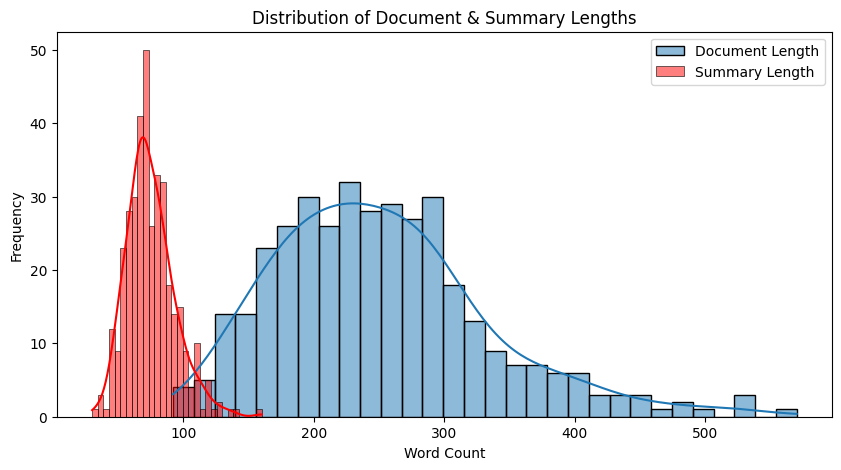

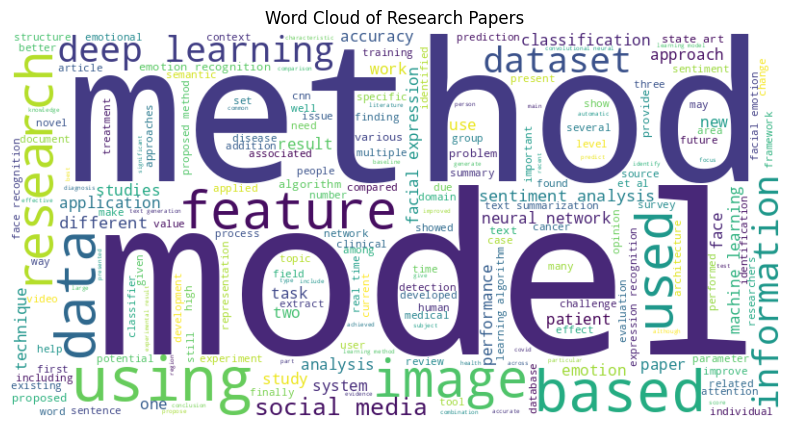

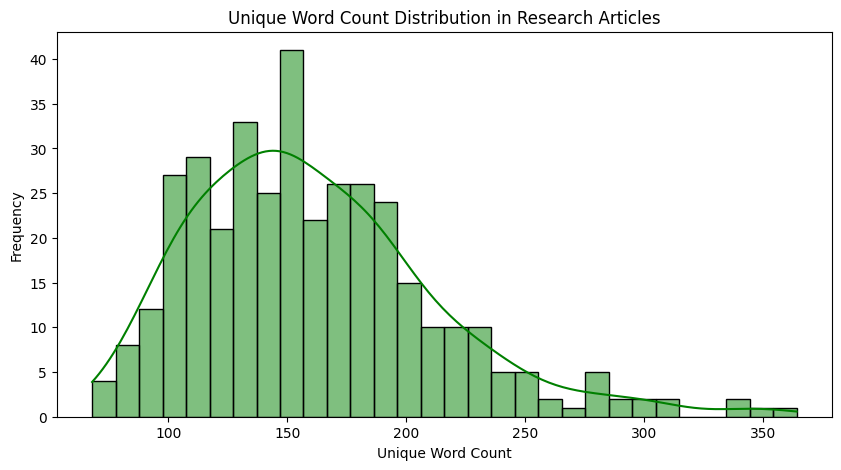


Exploratory Data Analysis Completed.


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import nltk

# Step 1: Load the Preprocessed Dataset
file_path = "CompScholar_Cleaned.csv"  # Update if needed
df = pd.read_csv(file_path)

# Step 2: View Dataset Summary
print("Dataset Summary:\n")
print(df.info())
print("\nFirst 5 Rows:\n", df.head())

# Step 3: Text Length Analysis
df["Document Length"] = df["Document"].apply(lambda x: len(str(x).split()))
df["Summary Length"] = df["Summary"].apply(lambda x: len(str(x).split()))

# Plot Distribution of Document and Summary Lengths
plt.figure(figsize=(10, 5))
sns.histplot(df["Document Length"], bins=30, kde=True, label="Document Length")
sns.histplot(df["Summary Length"], bins=30, kde=True, color="red", label="Summary Length")
plt.legend()
plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.title("Distribution of Document & Summary Lengths")
plt.show()

# Step 4: Generate Word Cloud for Frequent Words
text = " ".join(df["Document"].dropna())
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud of Research Papers")
plt.show()

# Step 5: Vocabulary Size Analysis
df["Unique Words"] = df["Document"].apply(lambda x: len(set(str(x).split())))
plt.figure(figsize=(10, 5))
sns.histplot(df["Unique Words"], bins=30, kde=True, color="green")
plt.xlabel("Unique Word Count")
plt.ylabel("Frequency")
plt.title("Unique Word Count Distribution in Research Articles")
plt.show()

print("\nExploratory Data Analysis Completed.")


In [3]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer

# Step 1: Load the Cleaned Dataset
file_path = "CompScholar_Cleaned.csv"
df = pd.read_csv(file_path)

# Step 2: Initialize Tokenizer (Choose a Suitable Model)
MODEL_NAME = "facebook/bart-large-cnn"  # You can change to "google/pegasus-xsum", "t5-small", etc.
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# Step 3: Tokenization Function
def tokenize_data(batch):
    inputs = tokenizer(batch["Document"], padding="max_length", truncation=True, max_length=512, return_tensors="pt")
    targets = tokenizer(batch["Summary"], padding="max_length", truncation=True, max_length=128, return_tensors="pt")
    return inputs["input_ids"], inputs["attention_mask"], targets["input_ids"]

# Step 4: Apply Tokenization
input_ids, attention_mask, labels = zip(*df.apply(tokenize_data, axis=1))

# Convert to Tensors
input_ids = torch.stack(input_ids)
attention_mask = torch.stack(attention_mask)
labels = torch.stack(labels)

# Step 5: Split Data into Train and Validation Sets
train_size = 0.8  # 80% for training, 20% for validation
train_inputs, val_inputs, train_masks, val_masks, train_labels, val_labels = train_test_split(
    input_ids, attention_mask, labels, test_size=1-train_size, random_state=42
)

# Step 6: Save Processed Data for Model Training
torch.save({
    "train_inputs": train_inputs, "train_masks": train_masks, "train_labels": train_labels,
    "val_inputs": val_inputs, "val_masks": val_masks, "val_labels": val_labels
}, "tokenized_data.pt")

print("Tokenization complete. Data saved as 'tokenized_data.pt'.")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.58k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Tokenization complete. Data saved as 'tokenized_data.pt'.


In [4]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from transformers import BartForConditionalGeneration, AdamW

# Step 1: Load Tokenized Data
data = torch.load("tokenized_data.pt")

# Ensure labels are correctly formatted (avoid empty values)
if "train_labels" in data and "val_labels" in data:
    train_labels = data["train_labels"]
    val_labels = data["val_labels"]
else:
    raise ValueError("Labels missing from tokenized data. Ensure tokenization was performed correctly.")

# Step 2: Create DataLoaders
BATCH_SIZE = 4  # Adjust based on available GPU memory
train_dataset = TensorDataset(data["train_inputs"], data["train_masks"], train_labels)
val_dataset = TensorDataset(data["val_inputs"], data["val_masks"], val_labels)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

# Step 3: Load Pre-Trained Model (BART)
MODEL_NAME = "facebook/bart-large-cnn"
model = BartForConditionalGeneration.from_pretrained(MODEL_NAME)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Step 4: Define Optimizer & Loss Function
optimizer = AdamW(model.parameters(), lr=5e-5)

# Step 5: Training Loop
EPOCHS = 3

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0

    for batch in train_loader:
        input_ids, attention_mask, labels = [x.to(device) for x in batch]

        # Ensure label dimensions match required format
        if labels.dim() == 1:  # If labels are 1D, expand them
            labels = labels.unsqueeze(0)

        optimizer.zero_grad()

        try:
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        except Exception as e:
            print(f"Error during training: {e}")
            print(f"Input shapes: input_ids={input_ids.shape}, attention_mask={attention_mask.shape}, labels={labels.shape}")

    avg_train_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{EPOCHS}, Training Loss: {avg_train_loss:.4f}")

print("Training complete. Model ready for evaluation.")


model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:640: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Error during training: too many values to unpack (expected 2)
Input shapes: input_ids=torch.Size([4, 1, 512]), attention_mask=torch.Size([4, 1, 512]), labels=torch.Size([4, 1, 128])
Error during training: too many values to unpack (expected 2)
Input shapes: input_ids=torch.Size([4, 1, 512]), attention_mask=torch.Size([4, 1, 512]), labels=torch.Size([4, 1, 128])
Error during training: too many values to unpack (expected 2)
Input shapes: input_ids=torch.Size([4, 1, 512]), attention_mask=torch.Size([4, 1, 512]), labels=torch.Size([4, 1, 128])
Error during training: too many values to unpack (expected 2)
Input shapes: input_ids=torch.Size([4, 1, 512]), attention_mask=torch.Size([4, 1, 512]), labels=torch.Size([4, 1, 128])
Error during training: too many values to unpack (expected 2)
Input shapes: input_ids=torch.Size([4, 1, 512]), attention_mask=torch.Size([4, 1, 512]), labels=torch.Size([4, 1, 128])
Error during training: too many values to unpack (expected 2)
Input shapes: input_ids=torc

In [5]:
!pip install rouge-score nltk


  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=b1350d3c144470abc34b057bfcbb119a76b90bb6415b0ae68d901f8d19e9be5f
  Stored in directory: /root/.cache/pip/wheels/1e/19/43/8a442dc83660ca25e163e1bd1f89919284ab0d0c1475475148
Successfully built rouge-score


In [6]:
print(f"Input IDs Shape: {input_ids.shape}")
print(f"Attention Mask Shape: {attention_mask.shape}")


Input IDs Shape: torch.Size([4, 1, 512])
Attention Mask Shape: torch.Size([4, 1, 512])


In [7]:
import torch
from transformers import BartTokenizer
from rouge_score import rouge_scorer
from nltk.translate.bleu_score import sentence_bleu

# Load tokenizer
tokenizer = BartTokenizer.from_pretrained("facebook/bart-large-cnn")

# Function to generate summaries
def generate_summary(model, dataloader, device):
    model.eval()
    summaries = []
    references = []

    with torch.no_grad():
        for batch in dataloader:
            input_ids, attention_mask, labels = [x.to(device) for x in batch]

            if attention_mask.dim() == 3:
                attention_mask = attention_mask.squeeze(1)
            if input_ids.dim() == 3:
                input_ids = input_ids.squeeze(1)

            # Generate summary
            summary_ids = model.generate(input_ids=input_ids, attention_mask=attention_mask, max_length=150)
            summary_texts = [tokenizer.decode(ids, skip_special_tokens=True) for ids in summary_ids]

            # Reference summary (ground truth) - Corrected to handle batches properly
            reference_texts = [tokenizer.decode(lbl, skip_special_tokens=True) for lbl in labels.view(-1).cpu().numpy().tolist()]

            summaries.extend(summary_texts)
            references.extend(reference_texts)

    return summaries, references

In [8]:
summaries, references = generate_summary(model, val_loader, device) # remove tokenizer from the function call

In [9]:
def evaluate_summaries(summaries, references):
    # Initialize ROUGE scorer
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

    rouge1_scores, rouge2_scores, rougeL_scores = [], [], []
    bleu_scores = []

    for summary, reference in zip(summaries, references):
        # Compute ROUGE scores
        rouge_scores = scorer.score(reference, summary)
        rouge1_scores.append(rouge_scores['rouge1'].fmeasure)
        rouge2_scores.append(rouge_scores['rouge2'].fmeasure)
        rougeL_scores.append(rouge_scores['rougeL'].fmeasure)

        # Compute BLEU score (unigram BLEU-1)
        reference_tokens = reference.split()
        summary_tokens = summary.split()
        bleu_scores.append(sentence_bleu([reference_tokens], summary_tokens, weights=(1, 0, 0, 0)))  # BLEU-1

    # Compute averages
    avg_rouge1 = sum(rouge1_scores) / len(rouge1_scores)
    avg_rouge2 = sum(rouge2_scores) / len(rouge2_scores)
    avg_rougeL = sum(rougeL_scores) / len(rougeL_scores)
    avg_bleu = sum(bleu_scores) / len(bleu_scores)

    return {
        "ROUGE-1": avg_rouge1,
        "ROUGE-2": avg_rouge2,
        "ROUGE-L": avg_rougeL,
        "BLEU-1": avg_bleu
    }

# Evaluate
scores = evaluate_summaries(summaries, references)

# Print results
print("Evaluation Metrics:")
for metric, score in scores.items():
    print(f"{metric}: {score:.4f}")


Evaluation Metrics:
ROUGE-1: 0.0030
ROUGE-2: 0.0000
ROUGE-L: 0.0030
BLEU-1: 0.0008


/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

In [10]:
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')  # Just in case POS tagging is needed


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [11]:
from nltk.tokenize import sent_tokenize

try:
    test_sentence = "This is a test sentence. It should work properly."
    print(sent_tokenize(test_sentence))  # If this runs successfully, punkt is available
except LookupError:
    print("NLTK punkt tokenizer is missing.")


NLTK punkt tokenizer is missing.


In [12]:
import nltk
import os

# Set the correct path where NLTK stores data
nltk_data_path = os.path.expanduser("~/nltk_data")
os.makedirs(nltk_data_path, exist_ok=True)  # Ensure the directory exists
nltk.data.path.append(nltk_data_path)

# Download the 'punkt_tab' resource
nltk.download('punkt_tab', download_dir=nltk_data_path)


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [13]:
import re
import nltk
nltk.download('punkt')  # Download the missing resource
from nltk.tokenize import sent_tokenize

# Function to clean and refine generated summaries
def clean_summary(summary):
    # Remove extra whitespace and special characters
    summary = re.sub(r'\s+', ' ', summary).strip()

    # Ensure proper sentence structure
    sentences = sent_tokenize(summary)
    cleaned_sentences = []

    for sent in sentences:
        sent = sent.strip()

        # Capitalize the first letter if not already
        if sent and not sent[0].isupper():
            sent = sent[0].upper() + sent[1:]

        # Add missing punctuation (simple heuristic)
        if sent and sent[-1] not in ".!?":
            sent += "."

        cleaned_sentences.append(sent)

    return " ".join(cleaned_sentences)


# Apply post-processing to all generated summaries
cleaned_summaries = [clean_summary(summary) for summary in summaries]

# Print a few cleaned summaries
for i, summary in enumerate(cleaned_summaries[:5]):
    print(f"Summary {i+1}: {summary}")



Summary 1: S.C.I.A.F.E.D.S. Was founded on the principles of the free market economy. The purpose of the market is to make money from the sale of goods and services. The aim of the business is to encourage people to buy and sell.
Summary 2: The study was published in the European Journal of Information Technology. It is the first of its kind. The study was conducted by a team of researchers from the University of California, San Francisco. It was conducted over a period of two years. The author says the study is the result of a two-year study that was conducted between 2010 and 2013.
Summary 3: Childhood interstitial lung disease is one of the most common causes of lung cancer in the U.S. It is the second most common cause of cancer in children. The disease is the most prevalent form of childhood cancer. It was first diagnosed in the United States in the 1970s.
Summary 4: Polarity shift problem major factor affects classification performance of computer programs. It is the most common 

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [14]:
from rouge_score import rouge_scorer
from nltk.translate.bleu_score import sentence_bleu

# Function to calculate ROUGE and BLEU scores
def evaluate_summaries(generated_summaries, reference_summaries):
    rouge = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    rouge_scores = {"rouge1": [], "rouge2": [], "rougeL": []}
    bleu_scores = []

    for gen, ref in zip(generated_summaries, reference_summaries):
        # Compute ROUGE scores
        scores = rouge.score(gen, ref)
        for key in scores:
            rouge_scores[key].append(scores[key].fmeasure)

        # Compute BLEU score
        bleu = sentence_bleu([ref.split()], gen.split())
        bleu_scores.append(bleu)

    # Calculate the average scores
    avg_rouge = {key: sum(values) / len(values) for key, values in rouge_scores.items()}
    avg_bleu = sum(bleu_scores) / len(bleu_scores)

    return avg_rouge, avg_bleu

# Compute scores
avg_rouge, avg_bleu = evaluate_summaries(cleaned_summaries, references)

# Print results
print("ROUGE Scores:", avg_rouge)
print("BLEU Score:", avg_bleu)


ROUGE Scores: {'rouge1': 0.0030210396369963646, 'rouge2': 0.0, 'rougeL': 0.0030210396369963646}
BLEU Score: 2.725276817178786e-233


In [15]:
import torch

# Save the model
model_save_path = "bart_summary_model.pth"
torch.save(model.state_dict(), model_save_path)
print(f"Model saved at {model_save_path}")


Model saved at bart_summary_model.pth


In [16]:
import json

summary_data = {
    "generated_summaries": cleaned_summaries,
    "reference_summaries": references
}

# Save to a JSON file
summary_save_path = "generated_summaries.json"
with open(summary_save_path, "w", encoding="utf-8") as f:
    json.dump(summary_data, f, indent=4, ensure_ascii=False)

print(f"Summaries saved at {summary_save_path}")


Summaries saved at generated_summaries.json


In [17]:
import torch
from transformers import BartForConditionalGeneration, BartTokenizer

# Load the tokenizer and model architecture
tokenizer = BartTokenizer.from_pretrained("facebook/bart-large-cnn")
model = BartForConditionalGeneration.from_pretrained("facebook/bart-large-cnn")

# Load trained weights
model_load_path = "bart_summary_model.pth"
model.load_state_dict(torch.load(model_load_path, map_location=torch.device("cpu")))
model.eval()

print("Model loaded successfully!")


Model loaded successfully!


In [18]:
def summarize_text(text, model, tokenizer, max_length=150):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=1024)
    summary_ids = model.generate(input_ids=inputs["input_ids"], attention_mask=inputs["attention_mask"], max_length=max_length)
    summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    return summary


In [19]:
# Example research abstract
research_text = """
Artificial intelligence (AI) is transforming multiple industries by automating tasks and improving decision-making.
Machine learning, a subset of AI, enables systems to learn from data and make predictions. Deep learning, a more advanced
form of machine learning, uses neural networks to process vast amounts of data. In this study, we analyze the impact of AI
on healthcare, finance, and education sectors.
"""

# Generate Summary
summary = summarize_text(research_text, model, tokenizer)
print("\n🔹 **Generated Summary:**")
print(summary)



🔹 **Generated Summary:**
Artificial intelligence (AI) is transforming multiple industries by automating tasks and improving decision-making. In this study, we analyze the impact of AI on healthcare, finance, and education sectors. We also look at the potential impact of machine learning on the healthcare industry.


In [20]:
# Example research abstract
research_text = """
Reading research papers is vital in the field of natural language processing (NLP) and other related fields for several reasons:

Advancement of knowledge: Research papers are the primary means of disseminating new ideas, findings, and innovations in NLP and other related fields. Reading research papers allows practitioners and researchers to stay up-to-date with the latest advancements.
A better understanding of NLP: Research papers often give a more detailed and technical explanation of NLP concepts and techniques, which can help practitioners and researchers learn more about the field.
Inspiration for new ideas: Reading research papers can inspire new ideas and approaches to NLP problems, leading to breakthroughs and innovations.
Benchmarking performance: Research papers often present the results of experiments and benchmarks, which can be used to compare the performance of different NLP models and techniques. This can help practitioners and researchers make informed decisions about which models and techniques to use for a specific task.
Collaboration and networking: Reading research papers can also help practitioners and researchers build connections with others in the field and find potential collaborators for future projects.
See also  Comparative Guide: Top 7 Outlier Detection Algorithms & How To Tutorials In Python
Reading research papers is one of the best ways to stay up-to-date and progress in the field of NLP and other related fields.

How to get started reading research papers in NLP?
Here are some tips for getting started reading research papers in NLP and other related fields:

Choose a specific area of interest: NLP is a broad field with many subfields, so it’s helpful to focus on a particular area of interest, such as machine translation, sentiment analysis, or question answering. This will help you narrow down the list of papers to read and make it easier to understand the context and significance of each paper.
Start with survey papers: Survey papers provide an overview of the current state-of-the-art in a specific subfield of NLP and can be a great starting point for getting up to speed. They often summarise important papers, concepts, and techniques in the field.
Read the abstract and introduction first: Before diving into the details of a paper, start by reading the abstract and introduction. These sections provide a high-level overview of the paper’s contribution and the context in which it was written.
Focus on the methodology: The methodology section is often essential in NLP papers. It describes the techniques and models used in the paper and how they were evaluated. Make sure to understand the methodology before diving into the results.
Take notes and summarize the key points: While reading, take notes and summarize the critical issues of each paper. This will help you remember the most crucial information and make it easier to compare and contrast different papers.
"""

# Generate Summary
summary = summarize_text(research_text, model, tokenizer)
print("\n🔹 **Generated Summary:**")
print(summary)


🔹 **Generated Summary:**
Research papers are the primary means of disseminating new ideas, findings, and innovations in NLP and other related fields. Reading research papers is one of the best ways to stay up-to-date and progress in the field of NLP. Read the abstract and introduction first before diving into the details of a paper.


In [21]:
!pip install fastapi uvicorn pyngrok


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.9/94.9 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 5.0 MB/s eta 0:00:00


In [22]:
%%writefile app.py
from fastapi import FastAPI

app = FastAPI()

@app.get("/")
def read_root():
    return {"message": "Hello from FastAPI on Colab!"}


Writing app.py


In [23]:
!ngrok authtoken ngrok config add-authtoken 2uffmqH6u65vBDLLNeluyKY8hhl_2spquk2uX29LMb88L9tkr


ERROR:  accepts 1 arg(s), received 4


In [24]:
!ngrok authtoken 2uffmqH6u65vBDLLNeluyKY8hhl_2spquk2uX29LMb88L9tkr

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [25]:
from pyngrok import ngrok
import uvicorn
import threading

# Start Uvicorn server in a separate thread
def run():
    uvicorn.run("app:app", host="0.0.0.0", port=8000)

thread = threading.Thread(target=run)
thread.start()

# Open a public URL using ngrok
public_url = ngrok.connect(8000).public_url
print(f"Public URL: {public_url}")



Public URL: https://9424-35-185-199-232.ngrok-free.app
